# Benchmarking FFT based methods for template matching
What is the fastest way to find the best in-plane rotation angle between two images? First we take a (log) polar transform of the images, so the problem is transformed into finding the best shift along axis 0 where the cross correlation is highest. Here this is implemented in 3 different ways:
* using cross-correlation via the FFT
* using a numpy/cupy vectorized implementation
* a numba JIT loop implementation

In [49]:
import numpy as np
import scipy.fft as fft
import matplotlib.pyplot as plt
from numba import njit, prange
from skimage.data import cat
from skimage.color import rgb2gray
from scipy.ndimage import rotate
from skimage.transform import warp_polar
from scipy import signal

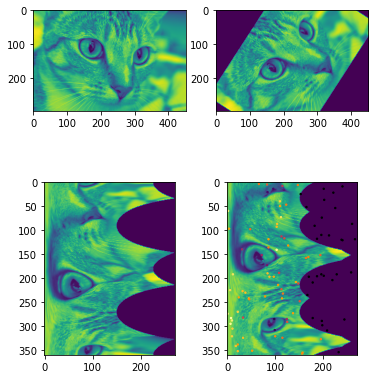

In [127]:
# setting the random seed for repeatability
seed = 1001
np.random.seed(seed)

# Generating a random polar image and template
ROTATION = 57  # the value to be found in degrees
im = rgb2gray(cat())
rot_im = rotate(im, ROTATION, reshape=False)
polar_im = warp_polar(im)
polar_rot_im = warp_polar(rot_im)

REFLECTIONS = 100  # the number of reflections
width = polar_im.shape[1]
height = polar_im.shape[0]
xy = np.stack([np.random.randint(0,height, size=(REFLECTIONS,)), np.random.randint(0, width, size=(REFLECTIONS,))])
intensity = polar_rot_im[xy[0], xy[1]]

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6, 7))
ax[0,0].imshow(im)
ax[0,1].imshow(rot_im)
ax[1,0].imshow(polar_im)
ax[1,1].imshow(polar_rot_im)
ax[1,1].scatter(xy[1], xy[0], c=intensity, s=2, cmap="inferno")
#plt.imshow(to_image(xy, intensity, width, height))

41
41
41


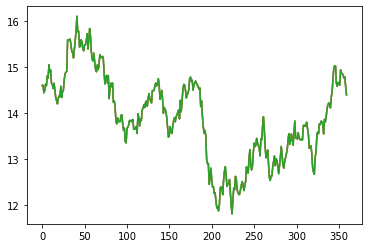

In [128]:
def to_image(xy, intensity, width, height):
    image = np.zeros((height, width))
    image[xy[0], xy[1]] = intensity
    return image


def fft_cc(image, xy, ints):
    template_image = to_image(xy, ints, image.shape[1], image.shape[0])
    fft_im = fft.rfftn(polar_im, axes=[0])
    fft_temp = fft.rfftn(template_image, axes=[0])
    image_product = fft_im * fft_temp.conj()
    cross_correlation = np.fft.irfftn(image_product, axes=[0]).sum(axis=1)
    return cross_correlation

def shift_cc(
    polar_image,
    xy,
    intensities,
    dispatcher = np,
):
    r_template = xy[1]
    theta_template = xy[0]
    sli = polar_image[:, r_template]
    rows, column_indices = dispatcher.ogrid[: sli.shape[0], : sli.shape[1]]
    rows = dispatcher.mod(rows + theta_template[None, :], polar_image.shape[0])
    extr = sli[rows, column_indices].astype(intensities.dtype)
    correlation = dispatcher.dot(extr, intensities)
    return correlation


@njit
def numba_cc(
    polar_image,
    xy,
    intensities,
):
    r = xy[1]
    theta = xy[0]
    height = polar_image.shape[0]
    correlation = np.zeros((height), dtype=np.float64)
    for shift in range(polar_image.shape[0]):
        for spot in range(r.shape[0]):
            correlation[shift] += polar_image[(theta[spot] + shift) % height, r[spot]]*intensities[spot]
    return correlation
    
    
def normalize(ar):
    return (ar - ar.min())/(ar.max() - ar.min())
    
fft_answer = fft_cc(polar_im, xy, intensity)
#plt.plot(normalize(fft_answer))
plt.plot(fft_answer)
shift_answer = shift_cc(polar_im, xy, intensity)
plt.plot(shift_answer)
#plt.plot(normalize(shift_answer))
numba_answer = numba_cc(polar_im, xy, intensity)
plt.plot(numba_answer)
print(np.argmax(fft_answer))
print(np.argmax(shift_answer))
print(np.argmax(numba_answer))

In [129]:
%%timeit

fft_cc(polar_im, xy, intensity)

962 µs ± 1.39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [130]:
%%timeit

shift_cc(polar_im, xy, intensity)

476 µs ± 4.06 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [131]:
%%timeit

numba_cc(polar_im, xy, intensity)

149 µs ± 8.69 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [132]:
from time import time
# let's make a plot of it
fft_times = []
shift_times = []
numba_times = []

seed = 1001
np.random.seed(seed)
ROTATION = 57  # the value to be found in degrees
im = rgb2gray(cat())
rot_im = rotate(im, ROTATION, reshape=False)
polar_im = warp_polar(im)
polar_rot_im = warp_polar(rot_im)

repeats = 1000
ns = [20, 100, 500, 1000, 10000]
for N in ns:
    REFLECTIONS = N  # the number of reflections
    width = polar_im.shape[1]
    height = polar_im.shape[0]
    xy = np.stack([np.random.randint(0,height, size=(REFLECTIONS,)), np.random.randint(0, width, size=(REFLECTIONS,))])
    intensity = polar_rot_im[xy[0], xy[1]]
    start = time()
    for repeat in range(repeats):
        fft_cc(polar_im, xy, intensity)
    stop = time()
    fft_times.append((stop-start)/repeats)
    start = time()
    for repeat in range(repeats):
        shift_cc(polar_im, xy, intensity)
    stop = time()
    shift_times.append((stop-start)/repeats)
    start = time()
    for repeat in range(repeats):
        numba_cc(polar_im, xy, intensity)
    stop = time()
    numba_times.append((stop-start)/repeats)
    print(f"Finished {N}")

Finished 20
Finished 100
Finished 500
Finished 1000
Finished 10000


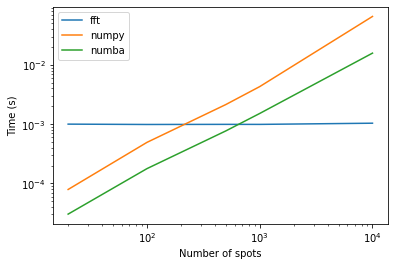

In [139]:
ns = [20, 100, 500, 1000, 10000]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(ns, fft_times, label="fft")
ax.plot(ns, shift_times, label="numpy")
ax.plot(ns, numba_times, label="numba")
ax.set_xlabel("Number of spots")
ax.set_ylabel("Time (s)")
ax.legend()